# Quantum Computing VIP (Vertically Integrated Project) @ Universidad Mayor
1st December 2021

## Digital Quantum Simulation

### Group members
- Melissa Silva
- Renata Martinez
- Jose Fredes
- Luciano Pineda

### Used libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, execute 
from qiskit.circuit import Parameter, Delay
from qiskit.providers.aer.noise import NoiseModel, phase_damping_error

from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere

QS = Aer.get_backend('qasm_simulator')

### Problem 1
Write down a general expression for the final state $\varphi(t)$ at the end of Ramsey and Echo sequences in terms of the initial state $\varphi_0$ and the pulse and evolution operators, $U(\frac{\pi}{2})_x$, $U(\frac{\pi}{2})_y$, $U(\pi)_x$ and $U(\tau)$. Draw the corresponding quantum circuits using Qiskit.


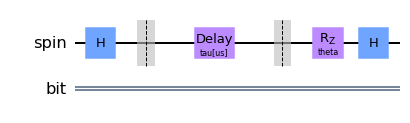

In [2]:
params = [Parameter('theta'), Parameter('tau')]
qr = QuantumRegister(1, 'spin')
cr = ClassicalRegister(1, 'bit')
qc_ramsey = QuantumCircuit(qr, cr)
qc_ramsey.h(qr)
qc_ramsey.barrier()
qc_ramsey.delay(params[1], qr, unit='us')
qc_ramsey.barrier()
qc_ramsey.rz(params[0], qr)
qc_ramsey.h(qr)
qc_ramsey.draw('mpl')

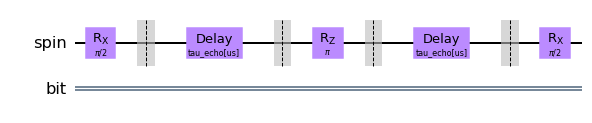

In [3]:
tau_echo = [Parameter('tau_echo')]
qr = QuantumRegister(1, 'spin')
cr = ClassicalRegister(1, 'bit')
qc_echo = QuantumCircuit(qr, cr)
qc_echo.rx(np.pi/2, 0)
qc_echo.barrier()
qc_echo.delay(tau_echo[0], qr, unit='us')
qc_echo.barrier()
qc_echo.rz(np.pi, 0)
qc_echo.barrier()
qc_echo.delay(tau_echo[0], qr, unit='us')
qc_echo.barrier()
qc_echo.rx(np.pi/2, 0)
qc_echo.draw('mpl')

### Problem 2

Consider an electronic spin 1/2 in the presence of an external magnetic field $B_0$ oriented along $\hat{z}$. In a frame rotating along the z-axis with frequency $\nu$, the Hamiltonian reads $H=(\gamma B_0 - 2\pi \nu )\sigma_z$. This interaction originates a time-evolution $U(\tau)$ that can be simulated with a phase gate in a quantum computer. Consider the qubit prepared in the initial state $\ket{g}$ (groundstate).

1. Consider a Ramsey sequence and calculate the probability of finding the initial state as a function of $\tau$. Make the plot using the ``statevector_simulator`` and the ``qasm_simulator``.
2. Repeat the same exercise for the Echo sequence.

#### Ramsey - QASM Simulator

First, we define a noise model that will interact with the $RZ$ gates.

In [4]:
phase_damping = phase_damping_error(0.5)
noise_model = NoiseModel()
noise_model.add_quantum_error(phase_damping,['rz'],[0])
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['rz']
  Qubits with noise: [0]
  Specific qubit errors: [('rz', [0])]


Then, we iteratively modify the following circuit to measure it over time with the given parameters.

In [5]:
gamma = 1  # MHz/G
B = 1      # G
t_points = 50
t_delay = np.linspace(0,6*np.pi,t_points)
p_0 = np.zeros(t_points)
shots = 4000
error_by_time_unit = 0.03

qr = QuantumRegister(1,'spin')
cr = ClassicalRegister(1,'bit')
circ = QuantumCircuit(qr,cr)
for time in range(0,t_points):
    circ.reset(qr)
    circ.h(qr)
    circ.delay(t_delay[time],qr,unit='us')
    circ.rz(gamma*B*t_delay[time],qr)
    circ.h(qr)
    circ.measure(qr,cr)
    phase_damping = phase_damping_error(error_by_time_unit*t_delay[time])
    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_damping,['rz'],[0])
    QS.set_options(noise_model=noise_model)
    job = execute(circ,QS,shots=shots)    
    result = job.result()
    counts = result.get_counts()
    p_0[time] = counts['0']/shots


Above, we have the ``error_by_time_unit`` variable which increases the phase damping over time.

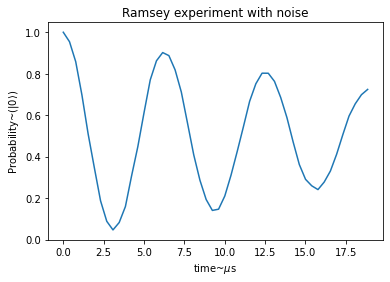

In [6]:
plt.figure()
plt.plot(t_delay,p_0)
plt.xlabel(r'time~$\mu$s')
plt.ylabel(r'Probability~($|0\rangle$)')
plt.title("Ramsey experiment with noise")
plt.show()

#### Ramsey - Statevector Simulator

ParameterView([Parameter(tau), Parameter(theta)])


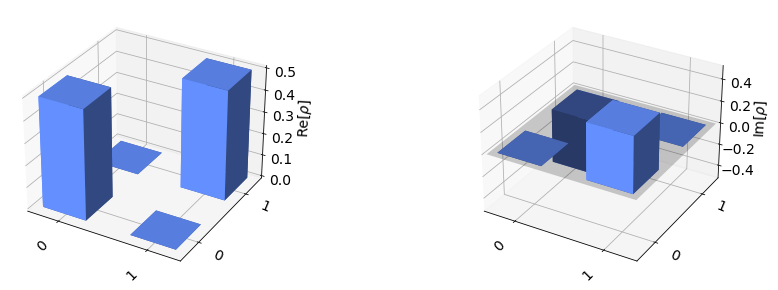

In [7]:
params = [Parameter('theta'), Parameter('tau')]
qr = QuantumRegister(1, 'spin')
cr = ClassicalRegister(1, 'bit')
qc_ramsey = QuantumCircuit(qr, cr)
qc_ramsey.h(qr)
qc_ramsey.barrier()
qc_ramsey.delay(params[1], qr, unit='us')
qc_ramsey.barrier()
qc_ramsey.rz(params[0], qr)
qc_ramsey.h(qr)
qc_ramsey.draw('mpl')

def ramsey_at_tau(circuit, params):
    print(qc_ramsey.parameters)
    circuit.assign_parameters(params, inplace=True)
    backend = Aer.get_backend('statevector_simulator')
    result = backend.run(transpile(circuit, backend)).result()
    psi  = result.get_statevector(circuit)
    return psi

ramsey_statevector_result = ramsey_at_tau(qc_ramsey, {params[0]: np.pi/2, params[1]: 10}) # tau = 10 us
plot_state_city(ramsey_statevector_result)

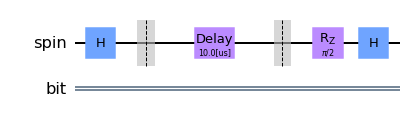

In [8]:
qc_ramsey.draw('mpl')

#### Echo - QASM Simulator

In [9]:
phase_damping = phase_damping_error(0.5)
noise_model = NoiseModel()
noise_model.add_quantum_error(phase_damping,['rz'],[0])
print(noise_model)
QS.set_options(noise_model=noise_model)

gamma = 1  # MHz/G
B = 1      # G
t_points = 50
t_delay = np.linspace(0,6*np.pi,t_points)
p_0 = np.zeros(t_points)
shots = 4000

error_by_time_unit = 0.03

qr = QuantumRegister(1,'spin')
cr = ClassicalRegister(1,'bit')
circ = QuantumCircuit(qr,cr)
for time in range(0,t_points):
    circ.reset(qr)
    circ.rx(np.pi/2,0)
    circ.delay(t_delay[time],qr,unit='us')
    circ.rz(np.pi,0)
    circ.delay(t_delay[time],qr,unit='us')
    circ.rx(np.pi/2,0)
    circ.measure(qr,cr)
    phase_damping = phase_damping_error(error_by_time_unit*t_delay[time])
    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_damping,['rz'],[0])
    QS.set_options(noise_model=noise_model)
    job = execute(circ,QS,shots=shots)    
    result = job.result()
    counts = result.get_counts()
    p_0[time] = counts['0']/shots


NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['rz']
  Qubits with noise: [0]
  Specific qubit errors: [('rz', [0])]


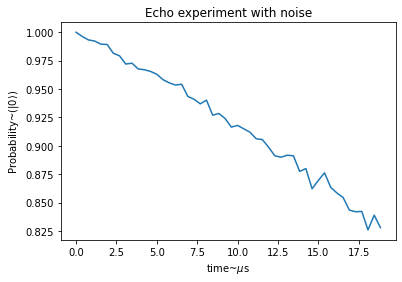

In [10]:
plt.figure()
plt.plot(t_delay,p_0)
plt.xlabel(r'time~$\mu$s')
plt.ylabel(r'Probability~($|0\rangle$)')
plt.title("Echo experiment with noise")
plt.show()

#### Echo - Statevector Simulator

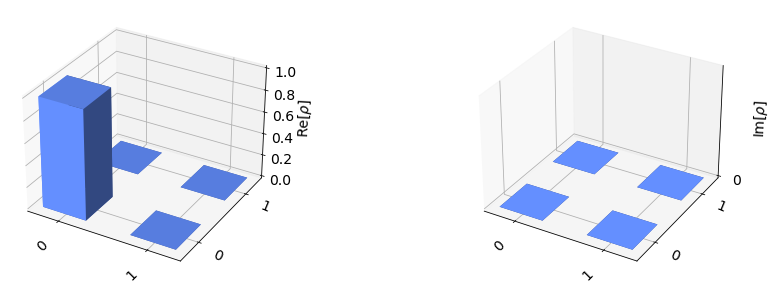

In [11]:
tau_echo = [Parameter('tau_echo')]
qr = QuantumRegister(1, 'spin')
qc_echo = QuantumCircuit(qr)
qc_echo.rx(np.pi/2, 0)
qc_echo.barrier()
qc_echo.delay(tau_echo[0], qr, unit='us')
qc_echo.barrier()
qc_echo.rz(np.pi, 0)
qc_echo.barrier()
qc_echo.delay(tau_echo[0], qr, unit='us')
qc_echo.barrier()
qc_echo.rx(np.pi/2, 0)

def echo_at_tau(circuit, tau_value):
    circuit.assign_parameters(tau_value, inplace=True)
    backend = Aer.get_backend('statevector_simulator')
    result = backend.run(transpile(circuit, backend)).result()
    psi  = result.get_statevector(circuit)
    return psi

plot_state_city(echo_at_tau(qc_echo, {tau_echo[0]: 5}))

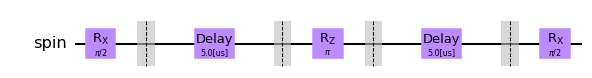

In [12]:
qc_echo.draw('mpl')
